In [55]:
import phasenet.zernike as Z
import phasenet.psf as P
import phasenet.model as M
from phasenet.phantoms import *

# Zernike

In [30]:
print(Z.Zernike(5, order='noll'))
print(Z.Zernike(3, order='ansi'))
print(Z.Zernike((2,-2)))
print(Z.Zernike('oblique astigmatism'))

Zernike(n=2, m=-2, noll= 5, ansi= 3, name='oblique astigmatism')
Zernike(n=2, m=-2, noll= 5, ansi= 3, name='oblique astigmatism')
Zernike(n=2, m=-2, noll= 5, ansi= 3, name='oblique astigmatism')
Zernike(n=2, m=-2, noll= 5, ansi= 3, name='oblique astigmatism')


In [31]:
for j in range(15):
    print(Z.Zernike(j, order='ansi'))

Zernike(n=0, m= 0, noll= 1, ansi= 0, name='piston')
Zernike(n=1, m=-1, noll= 3, ansi= 1, name='tilt')
Zernike(n=1, m= 1, noll= 2, ansi= 2, name='tip')
Zernike(n=2, m=-2, noll= 5, ansi= 3, name='oblique astigmatism')
Zernike(n=2, m= 0, noll= 4, ansi= 4, name='defocus')
Zernike(n=2, m= 2, noll= 6, ansi= 5, name='vertical astigmatism')
Zernike(n=3, m=-3, noll= 9, ansi= 6, name='vertical trefoil')
Zernike(n=3, m=-1, noll= 7, ansi= 7, name='vertical coma')
Zernike(n=3, m= 1, noll= 8, ansi= 8, name='horizontal coma')
Zernike(n=3, m= 3, noll=10, ansi= 9, name='oblique trefoil')
Zernike(n=4, m=-4, noll=15, ansi=10, name='oblique quadrafoil')
Zernike(n=4, m=-2, noll=13, ansi=11, name='oblique secondary astigmatism')
Zernike(n=4, m= 0, noll=11, ansi=12, name='primary spherical')
Zernike(n=4, m= 2, noll=12, ansi=13, name='vertical secondary astigmatism')
Zernike(n=4, m= 4, noll=14, ansi=14, name='vertical quadrafoil')


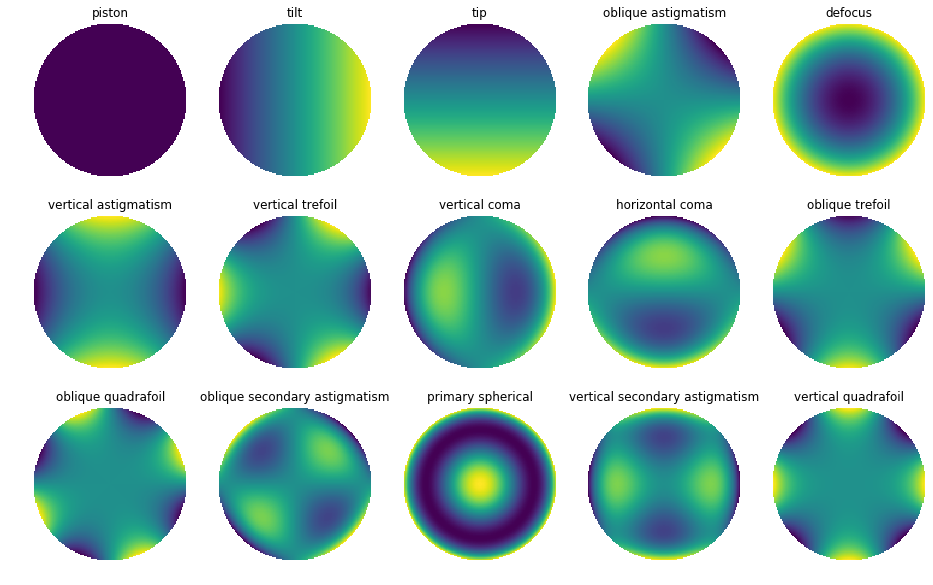

In [32]:
fig, ax = plt.subplots(3,5, figsize=(16,10))
for i,a in enumerate(ax.ravel()):
    z = Z.Zernike(i, order='ansi')
    w = z.polynomial(128)
    a.imshow(w)
    a.set_title(z.name)
    a.axis('off')
None;

## ZernikeWavefront

(0.5445659246627874, -0.3612421711970859, -0.5352356958668281, 0, -0.07618569816166398)
(0.5445659246627874, -0.5352356958668281, -0.3612421711970859, -0.07618569816166398)


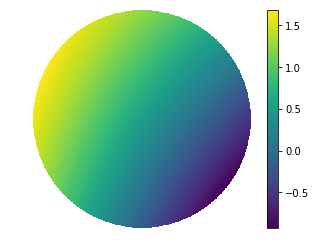

In [33]:
f = Z.ZernikeWavefront(np.random.uniform(-1,1,4), order='ansi')
f.zernikes

print(f.amplitudes_noll)
print(f.amplitudes_ansi)

plt.imshow(f.polynomial(512)); plt.colorbar(); plt.axis('off');

In [34]:
f = Z.random_zernike_wavefront([1,1,1], order='ansi')
print(f.amplitudes_requested, f.amplitudes_ansi)

f = Z.random_zernike_wavefront([0,0,(1,2)], order='ansi')
print(f.amplitudes_requested, f.amplitudes_ansi)

f = Z.random_zernike_wavefront({'defocus':(1,2), (3,-3):5})
print(f.amplitudes_requested, f.amplitudes_ansi)

(0.07486637408260588, 0.8823020375435953, -0.798854876533079) (0.07486637408260588, 0.8823020375435953, -0.798854876533079)
(0.0, 0.0, 1.8094271166432327) (0.0, 0.0, 1.8094271166432327)
(1.7820045422527218, 0.13023339709328852) (0, 0, 0, 0, 1.7820045422527218, 0, 0.13023339709328852)


# PSF

In [35]:
N = 64*1
dx = .1

psf = P.PsfGenerator3D(psf_shape=(N,)*3, units=(dx,)*3, na_detection=1.1, lam_detection=.5, n=1.33)

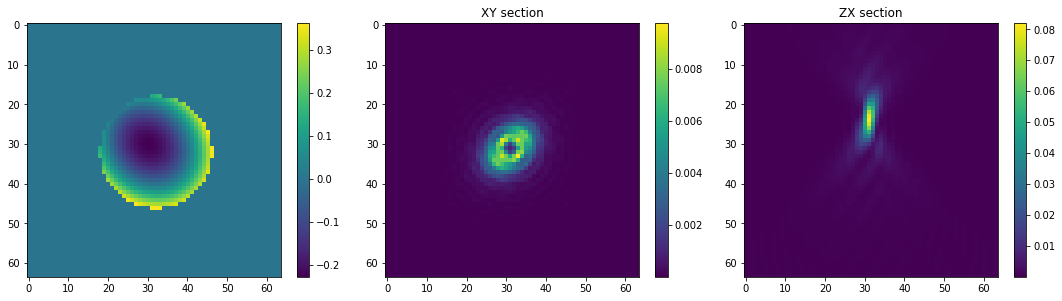

In [36]:
wf = Z.ZernikeWavefront(np.random.uniform(-0.2,0.2,5), order='ansi')
wf.zernikes

plt.figure(figsize=(15,4))
phase = wf.phase(psf.krho, psf.kphi, normed=True, outside=None)
phase = np.fft.fftshift(phase)
plt.subplot(131); plt.imshow(phase); plt.colorbar()

h1 = np.fft.fftshift(psf.incoherent_psf(wf, normed=True))
plt.subplot(132); plt.imshow(h1[N//2]);   plt.title('XY section'); plt.colorbar()
plt.subplot(133); plt.imshow(h1[:,N//2]); plt.title('ZX section'); plt.colorbar()
plt.tight_layout()
None;

## Data Generator

True
(3, 64, 64, 64, 1)
(3, 1)


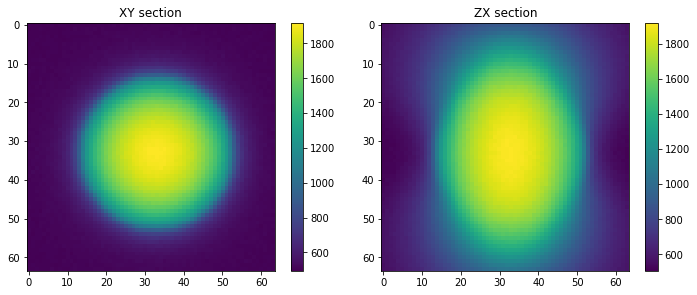

In [37]:
data = M.Data({'vertical coma':.0}, batch_size=3, noise_snr=(2,3), noise_mean=500, noise_sigma = 3.5, phantom_params={'name':'sphere', 'radius':2})
psfs, amps = next(data.generator())
print(data.phantom_flag)
print(psfs.shape)
print(amps.shape)
h1 = psfs[0,...,0]

N = h1.shape[0]
plt.figure(figsize=(10,4))
plt.subplot(121); plt.imshow(h1[N//2]);   plt.title('XY section'); plt.colorbar()
plt.subplot(122); plt.imshow(h1[:,N//2]); plt.title('ZX section'); plt.colorbar()
plt.tight_layout();

# Model

In [38]:
c = M.Config(psf_n=8)
vars(c)

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'zernike_amplitude_ranges': {'vertical coma': (-0.2, 0.2)},
 'zernike_order': 'noll',
 'zernike_normed': True,
 'net_kernel_size': (3, 3, 3),
 'net_pool_size': (1, 2, 2),
 'net_activation': 'tanh',
 'net_padding': 'same',
 'psf_shape': (64, 64, 64),
 'psf_units': (0.1, 0.1, 0.1),
 'psf_na_detection': 1.1,
 'psf_lam_detection': 0.5,
 'psf_n': 8,
 'noise_mean': 100,
 'noise_sigma': 3.5,
 'noise_snr': (1.0, 5),
 'phantom_params': {'name': 'points', 'num': 1},
 'crop_shape': (32, 32, 32),
 'jitter': True,
 'max_jitter': None,
 'train_loss': 'mse',
 'train_epochs': 400,
 'train_steps_per_epoch': 5,
 'train_learning_rate': 0.0003,
 'train_batch_size': 8,
 'train_n_val': 128,
 'train_tensorboard': True}

In [39]:
#model = M.PhaseNet(M.Config(), basedir=None)
model = M.PhaseNet(M.Config(), name='test', basedir='models')
vars(model.config)

/Users/dsaha/anaconda/lib/python3.6/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /Users/dsaha/Codes/phase_net_code/notebooks/models/test
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'zernike_amplitude_ranges': {'vertical coma': (-0.2, 0.2)},
 'zernike_order': 'noll',
 'zernike_normed': True,
 'net_kernel_size': (3, 3, 3),
 'net_pool_size': (1, 2, 2),
 'net_activation': 'tanh',
 'net_padding': 'same',
 'psf_shape': (64, 64, 64),
 'psf_units': (0.1, 0.1, 0.1),
 'psf_na_detection': 1.1,
 'psf_lam_detection': 0.5,
 'psf_n': 1.33,
 'noise_mean': 100,
 'noise_sigma': 3.5,
 'noise_snr': (1.0, 5),
 'phantom_params': {'name': 'points', 'num': 1},
 'crop_shape': (32, 32, 32),
 'jitter': True,
 'max_jitter': None,
 'train_loss': 'mse',
 'train_epochs': 400,
 'train_steps_per_epoch': 5,
 'train_learning_rate': 0.0003,
 'train_batch_size': 8,
 'train_n_val': 128,
 'train_tensorboard': True}

In [40]:
model.train(epochs=5)

/Users/dsaha/Codes/phase_net_code/phasenet/psf.py:47: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(1. * self.n ** 2 - KR3 ** 2 * lam_detection ** 2)


Epoch 1/5
5/5 [==============================] - 29s 6s/step - loss: 0.3859 - val_loss: 0.0287
Epoch 2/5
5/5 [==============================] - 28s 6s/step - loss: 0.0164 - val_loss: 0.0130
Epoch 3/5
5/5 [==============================] - 27s 5s/step - loss: 0.0233 - val_loss: 0.0189
Epoch 4/5
5/5 [==============================] - 26s 5s/step - loss: 0.0164 - val_loss: 0.0112
Epoch 5/5
5/5 [==============================] - 26s 5s/step - loss: 0.0161 - val_loss: 0.0111

Loading network weights from 'weights_best.h5'.


## Load model

In [58]:
model = M.PhaseNet(None, name='test', basedir='models')
vars(model.config)

Loading network weights from 'weights_best.h5'.


ValueError: Dimension 0 in both shapes must be equal, but are 16384 and 2048 for 'Assign_67' (op: 'Assign') with input shapes: [16384,64], [2048,64].

## Create test PSFs

In [56]:
data = M.Data(
    batch_size           = 128,
#     amplitude_ranges     = {'vertical coma': [-0.5, 0.5]},
    amplitude_ranges     = model.config.zernike_amplitude_ranges,
    order                = model.config.zernike_order,
    normed               = model.config.zernike_normed,
    psf_shape            = model.config.psf_shape,
    units                = model.config.psf_units,
    na_detection         = model.config.psf_na_detection,
    lam_detection        = model.config.psf_lam_detection,
    n                    = model.config.psf_n,
    noise_mean           = model.config.noise_mean,
    noise_snr            = model.config.noise_snr,
    noise_sigma          = model.config.noise_sigma,
    crop_shape           = model.config.crop_shape,
    jitter               = model.config.jitter,
    phantom_params       = model.config.phantom_params,
)
psfs, amps = next(data.generator())
psfs.shape
amps.shape

(128, 32, 32, 32, 1)

(128, 1)

## Predict and plot

In [57]:
# using keras model directly
_amps_pred = model.keras_model.predict(psfs, verbose=1)

128/128 [==============================] - 9s 68ms/step


In [54]:
amps_pred = np.stack([model.predict(psf) for psf in tqdm(psfs)])

TypeError: 'module' object is not callable

In [ ]:
print(_amps_pred.shape, amps_pred.shape)
np.allclose(_amps_pred.ravel(), amps_pred)

In [ ]:
plt.figure(figsize=(10,8))
ind = np.argsort(amps.ravel())
plt.plot(amps[ind], label='gt')
plt.plot(amps_pred[ind], '--', label='pred')
plt.hlines(-0.2, *plt.axis()[:2])
plt.hlines(+0.2, *plt.axis()[:2])
plt.xlabel('test psf')
plt.ylabel(f'amplitude {tuple(model.config.zernike_amplitude_ranges.keys())[0]}')
plt.legend()
None;